In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter


# V1X는 S&P500 의 V1X, V2X는 EURO의 V1X 지표. 2020.11.20~ 2024.11.19 최근 5년 일일데이터 사용

In [2]:
# 2020.11.20~ 2024.11.19 최근 5년 일일데이터 사용
snp=pd.read_csv('/Users/danielkhur/Documents/카이스트 MFE/MFE 2024-2학기/후반기/금융시계열분석(9-16)/3주차과제/CBOE Volatility Index Historical Data.csv')
euro=pd.read_csv('/Users/danielkhur/Documents/카이스트 MFE/MFE 2024-2학기/후반기/금융시계열분석(9-16)/3주차과제/STOXX 50 Volatility VSTOXX EUR Historical Data.csv')

In [3]:
snp=snp[['Date','Price']]
snp.head()

,Date,Price
0,11/20/2024,16.10
1,11/19/2024,16.35
2,11/18/2024,15.58
3,11/15/2024,16.14
4,11/14/2024,14.31


In [4]:
euro=euro[['Date','Price']]
euro.head()

,Date,Price
0,11/19/2024,19.23
1,11/18/2024,17.79
2,11/15/2024,17.21
3,11/14/2024,17.10
4,11/13/2024,17.68


In [5]:
snp.columns=['date','snpprice']
euro.columns=['date','europrice']

In [6]:
snp_euro=pd.merge(snp, euro, on='date', how='inner')
snp_euro

,date,snpprice,europrice
0,11/19/2024,16.35,19.23
1,11/18/2024,15.58,17.79
2,11/15/2024,16.14,17.21
3,11/14/2024,14.31,17.10
4,11/13/2024,14.02,17.68
...,...,...,...
1015,11/26/2020,21.25,20.23
1016,11/25/2020,21.25,20.78
1017,11/24/2020,21.64,21.37
1018,11/23/2020,22.66,22.49


In [7]:
snp_euro = snp_euro[::-1].reset_index(drop=True)
snp_euro

,date,snpprice,europrice
0,11/20/2020,23.70,21.44
1,11/23/2020,22.66,22.49
2,11/24/2020,21.64,21.37
3,11/25/2020,21.25,20.78
4,11/26/2020,21.25,20.23
...,...,...,...
1015,11/13/2024,14.02,17.68
1016,11/14/2024,14.31,17.10
1017,11/15/2024,16.14,17.21
1018,11/18/2024,15.58,17.79


In [8]:
v1x=snp_euro['snpprice'].values[::-1]
v2x=snp_euro['europrice'].values[::-1]
dates=snp_euro['date'].values[::-1]

# 1. V1X와 V2X의 시계열을 추세, 계절성 및 잡음으로 분해하라.

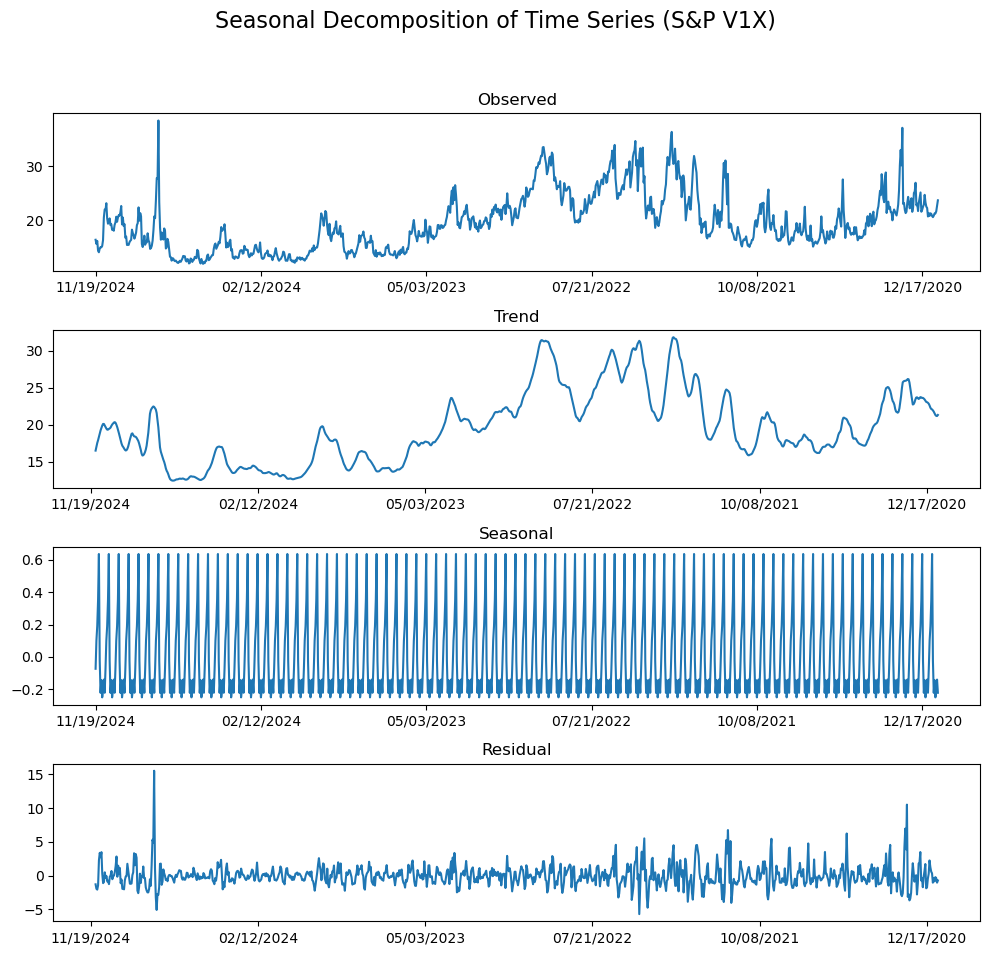

In [9]:
decomposition_snp = sm.tsa.seasonal_decompose(v1x, model='additive', period = 12) 
y = pd.Series(v1x, index=dates)
observed = pd.Series(decomposition_snp.observed, index=y.index)
trend = pd.Series(decomposition_snp.trend, index=y.index)
seasonal = pd.Series(decomposition_snp.seasonal, index=y.index)
resid = pd.Series(decomposition_snp.resid, index=y.index)

# Plot the decomposition with a title
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
fig.suptitle('Seasonal Decomposition of Time Series (S&P V1X)', fontsize=16)

observed.plot(ax=ax1, title='Observed', legend=False)
trend.plot(ax=ax2, title='Trend', legend=False)
seasonal.plot(ax=ax3, title='Seasonal', legend=False)
resid.plot(ax=ax4, title='Residual', legend=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

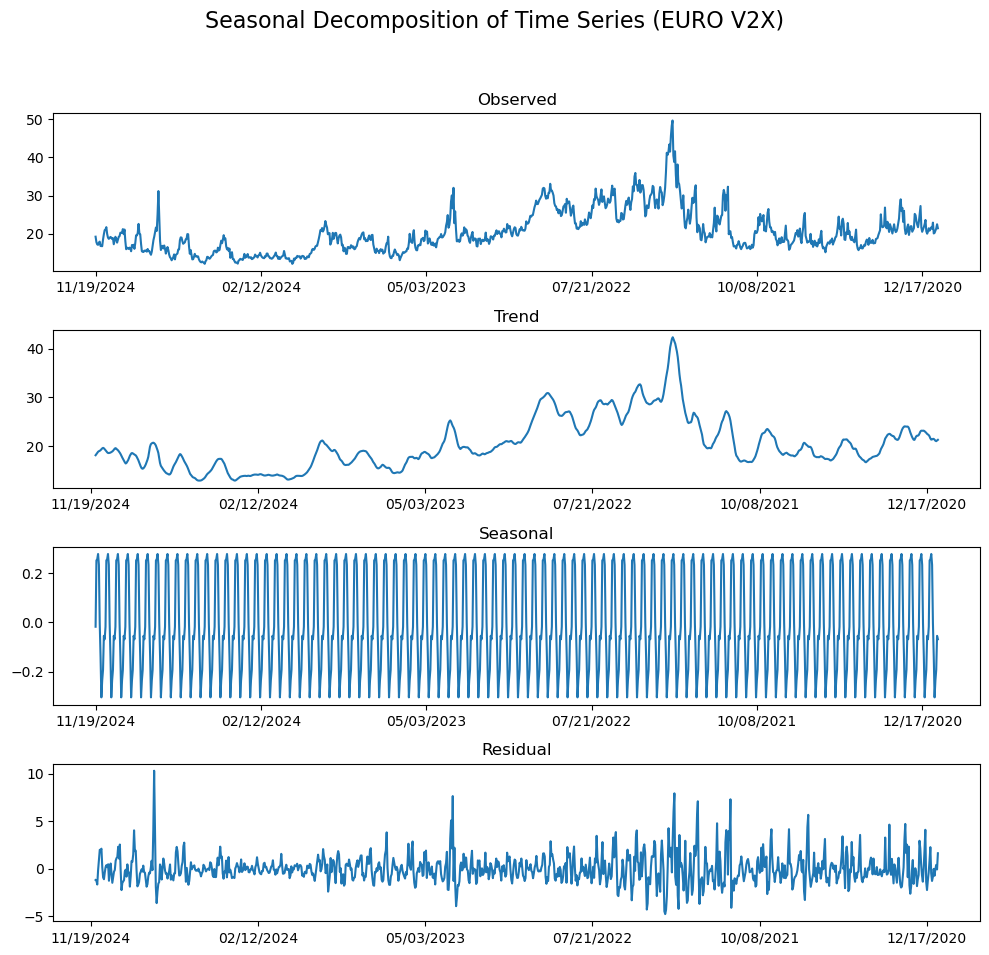

In [10]:
decomposition_euro = sm.tsa.seasonal_decompose(v2x, model='additive', period = 12) 
y = pd.Series(v2x, index=dates)
observed = pd.Series(decomposition_euro.observed, index=y.index)
trend = pd.Series(decomposition_euro.trend, index=y.index)
seasonal = pd.Series(decomposition_euro.seasonal, index=y.index)
resid = pd.Series(decomposition_euro.resid, index=y.index)

# Plot the decomposition with a title
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
fig.suptitle('Seasonal Decomposition of Time Series (EURO V2X)', fontsize=16)

observed.plot(ax=ax1, title='Observed', legend=False)
trend.plot(ax=ax2, title='Trend', legend=False)
seasonal.plot(ax=ax3, title='Seasonal', legend=False)
resid.plot(ax=ax4, title='Residual', legend=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

# 2. V1X와 V2X 각각에 대해 단위근 테스트를 실행하고 정상성을 살펴보라.

In [11]:
y = pd.Series(v1x, index=dates)

# Augmented Dickey-Fuller test
result = adfuller(y)

# Extracting the results
print('ADF Statistic for V1X:', result[0])
print('V1X p-value:', result[1])
print('V1X Critical Values:', result[4])

# Interpretation
if result[1] <= 0.05:
    print("The V1X time series is stationary (reject the null hypothesis of unit root).")
else:
    print("The V1X time series is non-stationary (fail to reject the null hypothesis of unit root).")

ADF Statistic for V1X: -4.577356433164721
V1X p-value: 0.0001421688174983447
V1X Critical Values: {'1%': -3.4367899468008916, '5%': -2.8643833180472744, '10%': -2.5682839089705536}
The V1X time series is stationary (reject the null hypothesis of unit root).


In [12]:
y = pd.Series(v2x, index=dates)

# Augmented Dickey-Fuller test
result = adfuller(y)

# Extracting the results
print('ADF Statistic for V2X:', result[0])
print('V2X p-value:', result[1])
print('V2X Critical Values:', result[4])

# Interpretation
if result[1] <= 0.05:
    print("The V2X time series is stationary (reject the null hypothesis of unit root).")
else:
    print("The V2X time series is non-stationary (fail to reject the null hypothesis of unit root).")

ADF Statistic for V2X: -3.651900717430071
V2X p-value: 0.0048428953137901265
V2X Critical Values: {'1%': -3.436802656106708, '5%': -2.8643889233382502, '10%': -2.5682868944525388}
The V2X time series is stationary (reject the null hypothesis of unit root).


# V1X, V2X 다 정상성이라는 결과가 나왔다. 

# 3. V1X와 V2X 각각에 대해 ARIMA GARCH 모델을 적용하라.

/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1020
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1939.948
Date:                Sat, 23 Nov 2024   AIC                           3885.896
Time:                        22:25:53   BIC                           3900.676
Sample:                             0   HQIC                          3891.508
                               - 1020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8539      0.017     49.317      0.000       0.820       0.888
ma.L1         -0.9643      0.013    -76.663      0.000      -0.989      -0.940
sigma2         2.6358      0.050     52.934      0.0

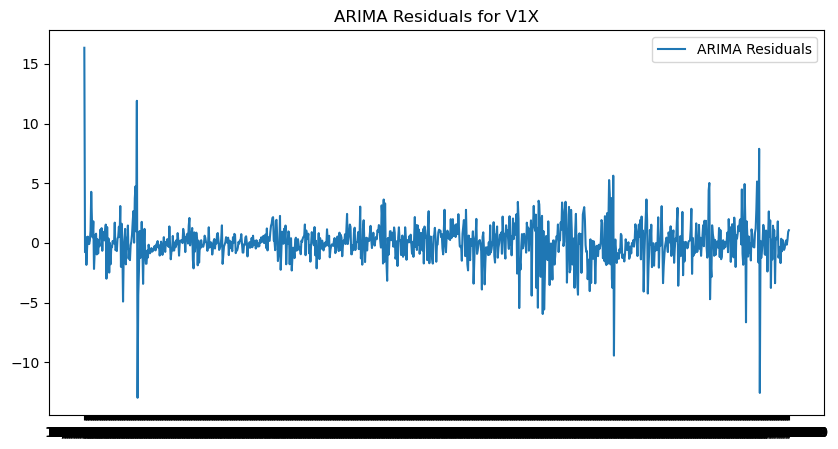

In [13]:
# V1X에 대해 ARIMA, GARCH(1,1)을 각각 적용
v1x_series = pd.Series(v1x, index=dates)
# Fit ARIMA model (Example: ARIMA(1, 1, 1))
arima_model = ARIMA(v1x_series, order=(1, 1, 1))
arima_result = arima_model.fit()

# Summary of the ARIMA model
print(arima_result.summary())

# Plot residuals
residuals_v1x = arima_result.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals_v1x, label='ARIMA Residuals')
plt.title('ARIMA Residuals for V1X')
plt.legend()
plt.show()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 5460.355302477197
Iteration:      2,   Func. Count:     15,   Neg. LLF: 16720569767.454468
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1977.954413765081
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1724.9459216407229
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2386.9211992498626
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1724.6748095919174
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1724.657354171313
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1724.6570462283162
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1724.6570169723693
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1724.6570169732124
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1724.6570169723693
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results       

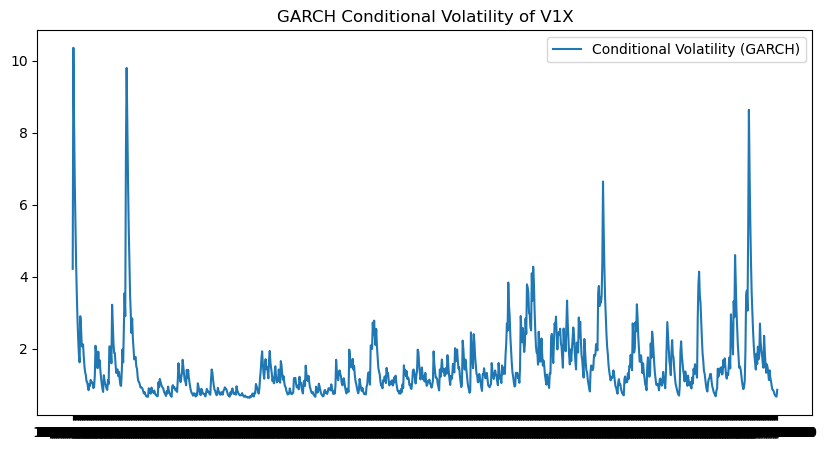

In [14]:
# Fit GARCH(1, 1) model to ARIMA residuals
garch_model = arch_model(residuals_v1x, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Summary of the GARCH model
print(garch_result.summary())

# Plot the volatility
plt.figure(figsize=(10, 5))
plt.plot(garch_result.conditional_volatility, label='Conditional Volatility (GARCH)')
plt.title('GARCH Conditional Volatility of V1X')
plt.legend()
plt.show()


/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/kaist311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1020
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1912.718
Date:                Sat, 23 Nov 2024   AIC                           3831.436
Time:                        22:26:09   BIC                           3846.216
Sample:                             0   HQIC                          3837.048
                               - 1020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8793      0.017     51.513      0.000       0.846       0.913
ma.L1         -0.9675      0.010    -93.272      0.000      -0.988      -0.947
sigma2         2.4988      0.059     42.494      0.0

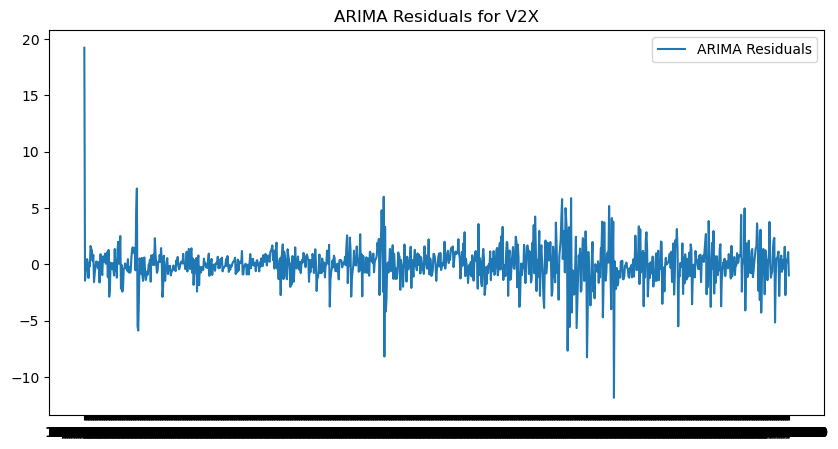

In [15]:
# V2X에 대해 ARIMA, GARCH(1,1)을 각각 적용
v2x_series = pd.Series(v2x, index=dates)
# Fit ARIMA model (Example: ARIMA(1, 1, 1))
arima_model = ARIMA(v2x_series, order=(1, 1, 1))
arima_result = arima_model.fit()

# Summary of the ARIMA model
print(arima_result.summary())

# Plot residuals
residuals_v2x = arima_result.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals_v2x, label='ARIMA Residuals')
plt.title('ARIMA Residuals for V2X')
plt.legend()
plt.show()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 5509.199206629761
Iteration:      2,   Func. Count:     16,   Neg. LLF: 13947281300.49898
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1990.5300427485406
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1740.0077261930462
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1739.7814402763106
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1739.7008481047037
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1739.6983891311197
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1739.6976567006436
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1739.697656099589
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1739.697656099589
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:          

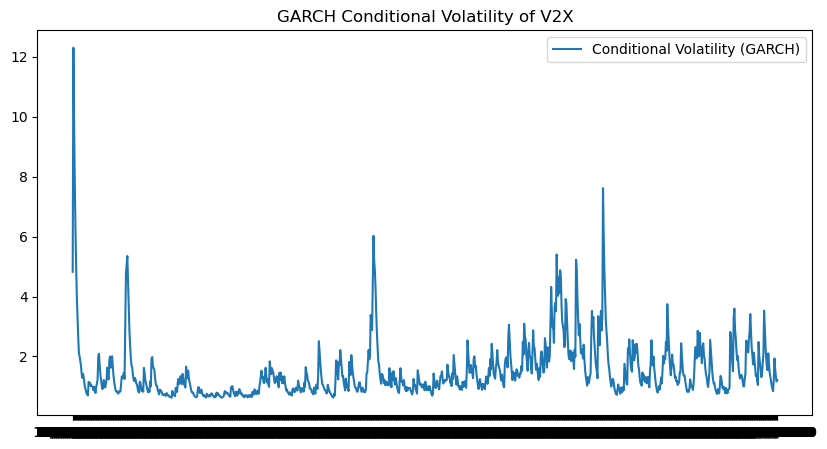

In [16]:
# Fit GARCH(1, 1) model to ARIMA residuals
garch_model = arch_model(residuals_v2x, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Summary of the GARCH model
print(garch_result.summary())

# Plot the volatility
plt.figure(figsize=(10, 5))
plt.plot(garch_result.conditional_volatility, label='Conditional Volatility (GARCH)')
plt.title('GARCH Conditional Volatility of V2X')
plt.legend()
plt.show()


# 4. V1X와 V2X에 대해 Multivariate GARCH 모델를 적용해보라.

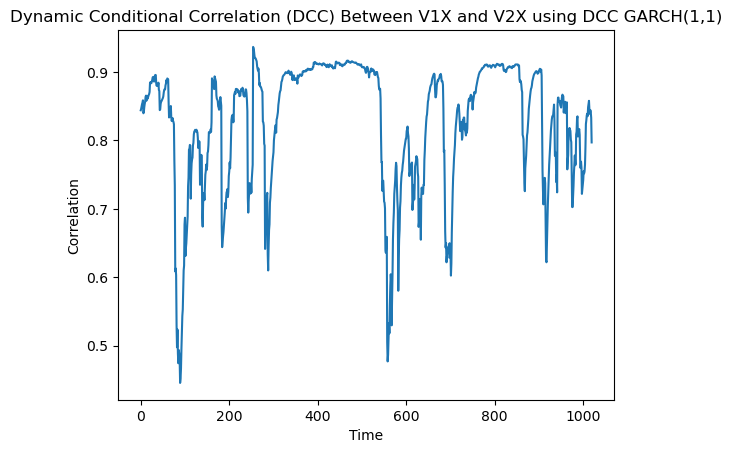

In [17]:
returns = pd.DataFrame({'V1X': snp_euro['snpprice'], 'V2X': snp_euro['europrice']}).dropna()

# Step 2: Fit Univariate GARCH(1,1) for each series
v1x_garch = arch_model(returns['V1X'], vol='Garch', p=1, q=1).fit(disp="off")
v2x_garch = arch_model(returns['V2X'], vol='Garch', p=1, q=1).fit(disp="off")

# Extract standardized residuals
v1x_std_resid = v1x_garch.resid / v1x_garch.conditional_volatility
v2x_std_resid = v2x_garch.resid / v2x_garch.conditional_volatility

# Combine standardized residuals
std_residuals = np.column_stack((v1x_std_resid, v2x_std_resid))

# Step 3: Initialize DCC-GARCH parameters
T, k = std_residuals.shape
Q_bar = np.cov(std_residuals.T)  # Unconditional covariance matrix
Q = Q_bar.copy()
alpha, beta = 0.05, 0.9  # DCC parameters (to be tuned)
R_matrices = np.zeros((T, k, k))  # Store dynamic correlation matrices

# Step 4: Estimate Dynamic Conditional Correlation (DCC)
for t in range(T):
    # Update Q_t (dynamic covariance matrix)
    outer_product = np.outer(std_residuals[t], std_residuals[t])
    Q = (1 - alpha - beta) * Q_bar + alpha * outer_product + beta * Q

    # Convert Q to correlation matrix R
    diag_Q = np.sqrt(np.diag(Q))
    R = Q / np.outer(diag_Q, diag_Q)  # Normalize to get correlation matrix
    R_matrices[t] = R

# Step 5: Extract and visualize dynamic correlations
dynamic_corr = [R[0, 1] for R in R_matrices]

# Plot dynamic correlations
plt.plot(dynamic_corr)
plt.title("Dynamic Conditional Correlation (DCC) Between V1X and V2X using DCC GARCH(1,1)")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()



# 5. V1X와 V2X를 이용해 VAR 모델을 만들고, Granger causality 테스트를 실행하고, Impulse response 그래프와 분산 분해(Varinace Decomposion)을 계산하고 그래프로 보여라.


In [18]:
# VAR 모델 생성
model = VAR(returns)

# Select the optimal lag order using AIC
lag_order = model.select_order(maxlags=10)
print("Optimal lag order based on AIC:", lag_order.aic)

# Fit the model
var_model = model.fit(lag_order.aic)
print(var_model.summary())



Optimal lag order based on AIC: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Nov, 2024
Time:                     22:26:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.45074
Nobs:                     1015.00    HQIC:                   1.38457
Log likelihood:          -3540.55    FPE:                    3.83453
AIC:                      1.34404    Det(Omega_mle):         3.75275
--------------------------------------------------------------------
Results for equation V1X
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.728282         0.207273            3.514           0.000
L1.V1X         0.795161         0.040569           19.600           0.000
L1.V2X         0.089093         0.043231            2.06

In [19]:
# granger-casuality 테스트 진행
print("Granger Causality Test:")
grangercausalitytests(returns, maxlag=lag_order.aic)



Granger Causality Test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8572  , p=0.0017  , df_denom=1016, df_num=1
ssr based chi2 test:   chi2=9.8863  , p=0.0017  , df=1
likelihood ratio test: chi2=9.8386  , p=0.0017  , df=1
parameter F test:         F=9.8572  , p=0.0017  , df_denom=1016, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4059  , p=0.0336  , df_denom=1013, df_num=2
ssr based chi2 test:   chi2=6.8454  , p=0.0326  , df=2
likelihood ratio test: chi2=6.8225  , p=0.0330  , df=2
parameter F test:         F=3.4059  , p=0.0336  , df_denom=1013, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5204  , p=0.0566  , df_denom=1010, df_num=3
ssr based chi2 test:   chi2=7.6137  , p=0.0547  , df=3
likelihood ratio test: chi2=7.5853  , p=0.0554  , df=3
parameter F test:         F=2.5204  , p=0.0566  , df_denom=1010, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

{1: ({'ssr_ftest': (9.857170206025392, 0.001740533773435866, 1016.0, 1),
   'ssr_chi2test': (9.886276023562868, 0.0016651601890105418, 1),
   'lrtest': (9.838625950065762, 0.0017088509754639536, 1),
   'params_ftest': (9.85717020602458, 0.0017405337734365432, 1016.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.4058829598048312, 0.03355790371009107, 1013.0, 2),
   'ssr_chi2test': (6.84538766649816, 0.032624431680392814, 2),
   'lrtest': (6.822474935470382, 0.033000338244488836, 2),
   'params_ftest': (3.4058829598047935, 0.03355790371009459, 1013.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.520424551760578, 0.05661948987987152, 1010.0, 3),
   'ssr_chi2test': (7.613678522199528, 0.05470839366218026, 3),
   'lrtest': (7.585320410044005, 0.055406259842024644, 3),
   'params_ftest': (2.520424551760658, 0.05661948987986885, 1010.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
       

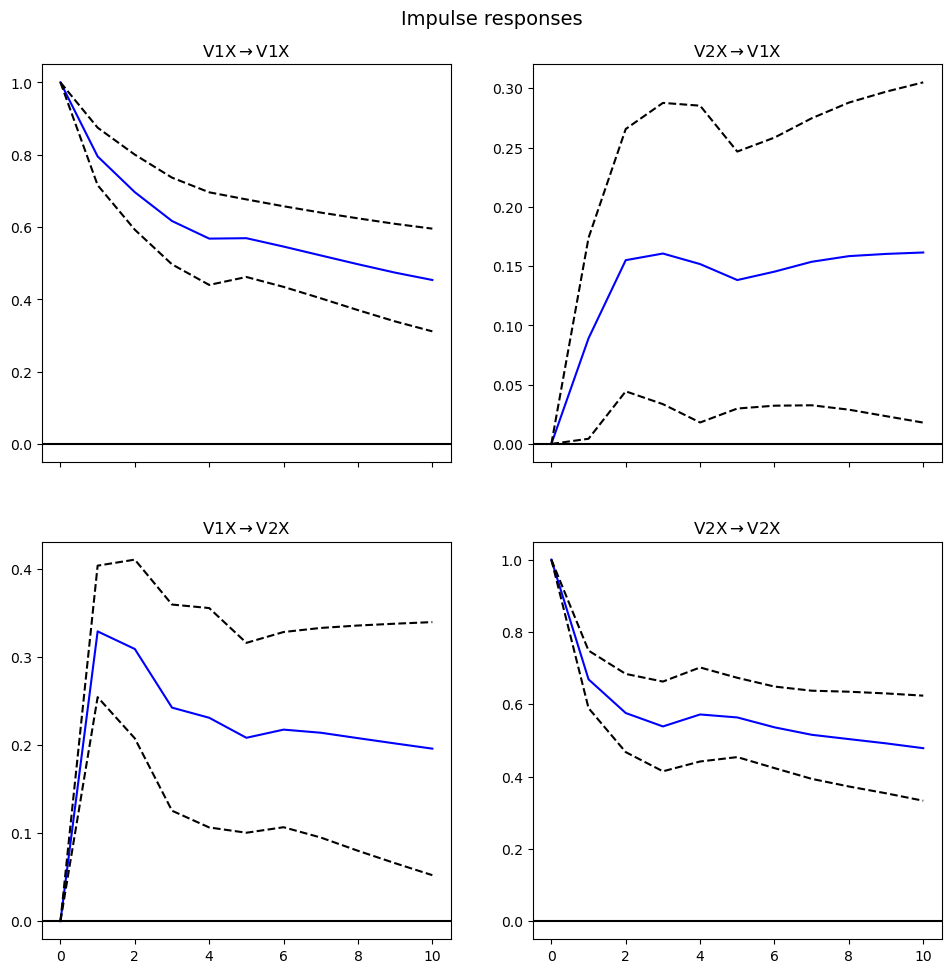

In [20]:
# impulse response 계산
irf = var_model.irf(10)  # Impulse response for 10 steps ahead

# Plot impulse response functions
irf.plot(orth=False)
plt.show()


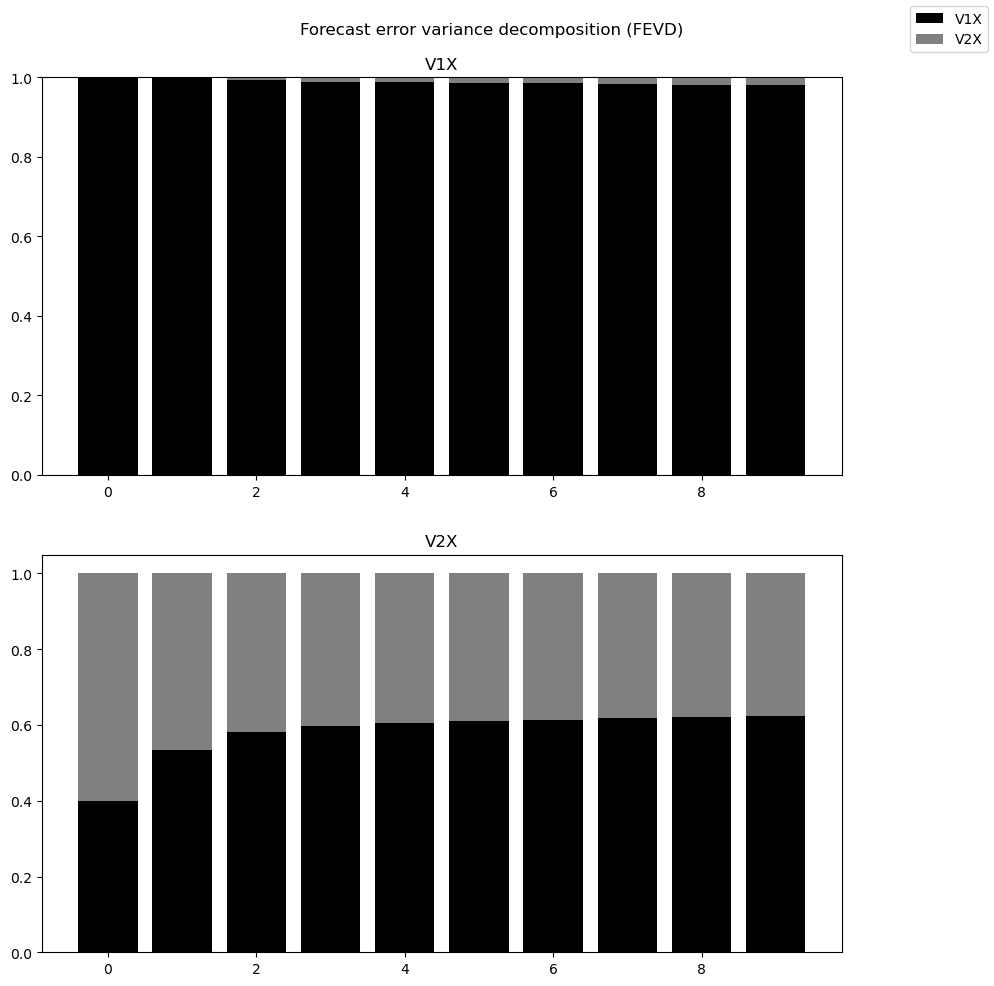

In [21]:
# variance decomposition 계산 후 그래프로 표현
fevd = var_model.fevd(10)  # 10-step ahead variance decomposition

# Plot variance decomposition
fevd.plot()
plt.show()

# 6. V1X와 V2X를 이용해 공적분관계를 확인하고, VECM 모델을 구축하라.

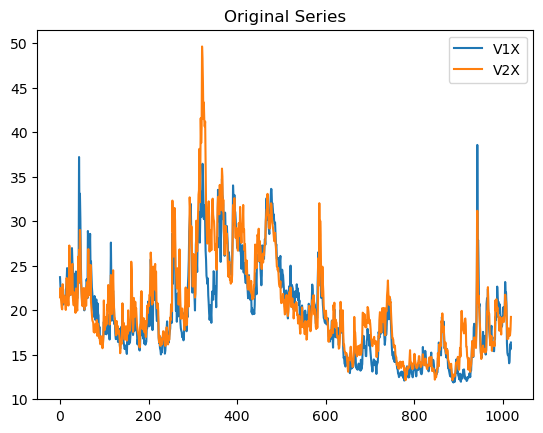

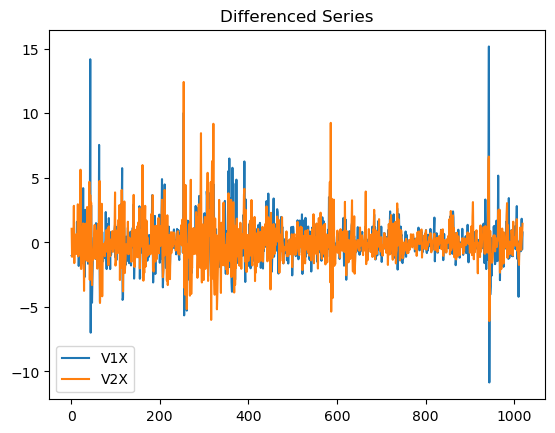

In [22]:
# 2. Load and Prepare Data
# Assuming V1X and V2X are your time series arrays
# Combine them into a DataFrame
data = returns

# Check stationarity of individual series using differencing (if needed)
data_diff = data.diff().dropna()

# Visualize
data.plot(title="Original Series")
plt.show()

data_diff.plot(title="Differenced Series")
plt.show()


In [23]:
# 3. Check for Cointegration Using Johansen Test
# Johansen Test for Cointegration
result = coint_johansen(data, det_order=0, k_ar_diff=1)  # det_order=0 assumes no deterministic trend
trace_stat = result.lr1  # Trace statistics
crit_values = result.cvt  # Critical values

# Print results
print("Johansen Cointegration Test")
print(f"Trace Statistics: {trace_stat}")
print(f"Critical Values:\n{crit_values}")

# Check if Trace Statistics > Critical Values for cointegration
if trace_stat[0] > crit_values[0, 1]:  # Compare with 5% critical value
    print("Cointegration exists at the 5% significance level.")
else:
    print("No cointegration at the 5% significance level.")


Johansen Cointegration Test
Trace Statistics: [75.12335838 17.92882275]
Critical Values:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Cointegration exists at the 5% significance level.


In [24]:
# 4. Construct VECM Model
# Once cointegration is confirmed, construct a VECM model.
# Fit VECM model
vecm = VECM(data, k_ar_diff=1, coint_rank=1)  # coint_rank=1 for one cointegrating relationship
vecm_fit = vecm.fit()

# Display VECM summary
print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation V1X
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.V1X        -0.0937      0.039     -2.378      0.017      -0.171      -0.016
L1.V2X        -0.0021      0.040     -0.053      0.958      -0.080       0.076
Det. terms outside the coint. relation & lagged endog. parameters for equation V2X
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.V1X         0.2316      0.037      6.221      0.000       0.159       0.305
L1.V2X        -0.2034      0.038     -5.398      0.000      -0.277      -0.130
                Loading coefficients (alpha) for equation V1X                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

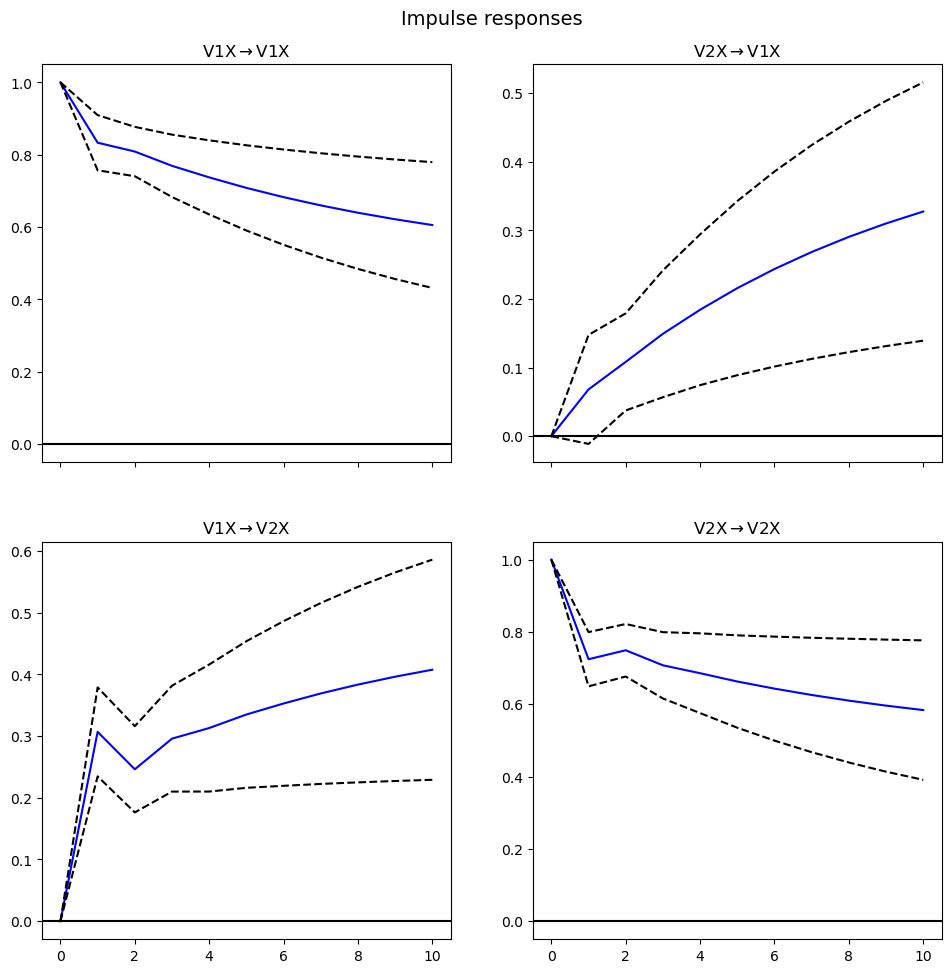

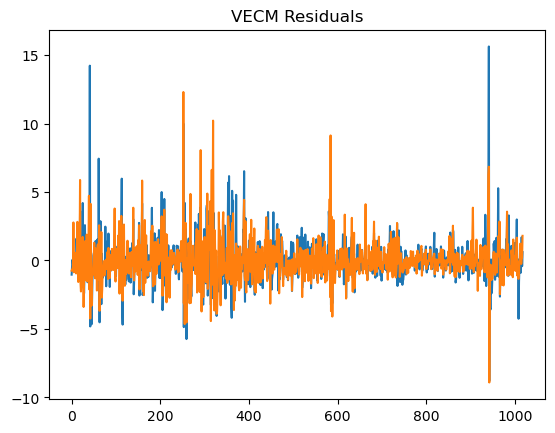

In [25]:
# 5. Impulse Response and Diagnostics
# After fitting the VECM model, you can analyze impulse responses or conduct model diagnostics.
# Impulse Response Analysis
irf = vecm_fit.irf(10)  # Impulse response for 10 periods
irf.plot()
plt.show()

# Diagnostics (Residuals)
vecm_resid = vecm_fit.resid
plt.plot(vecm_resid)
plt.title("VECM Residuals")
plt.show()


# 7. 페어트레이딩 (트레이딩 경계: 평균 +/- some 표준편차)
# (1) 단순 스프레드를 이용한 페어 트레이딩, (2) 공적분관계를 이용한 페어트레이딩, 
# (3) 칼만 필터를 이용한 페어트레이딩

In [ ]:
data=returns
entry_threshold = 1  # Entry threshold in terms of standard deviations
exit_threshold = 0   # Exit when spread returns to mean


# Function to calculate trading signals
def generate_signals(spread, mean, std_dev, entry_threshold, exit_threshold):
    signals = pd.DataFrame(index=spread.index, columns=['Spread', 'Position'])
    signals['Spread'] = spread

    # Entry and exit signals
    signals['Position'] = np.where(spread > mean + entry_threshold * std_dev, -1,  # Short
                                   np.where(spread < mean - entry_threshold * std_dev, 1,  # Long
                                            0))  # Exit
    return signals


# Pair Trading Using Simple Spread
def pair_trading_simple(data):
    # Calculate spread as the difference between the two series
    spread = data['V1X'] - data['V2X']
    mean = spread.mean()
    std_dev = spread.std()

    # Generate trading signals
    signals = generate_signals(spread, mean, std_dev, entry_threshold, exit_threshold)
    return signals


# Pair Trading Using Cointegration
def pair_trading_coint(data):
    # Cointegration test
    _, p_value, _ = coint(data['V1X'], data['V2X'])
    if p_value > 0.05:
        raise ValueError("No cointegration relationship found")

    # Calculate spread using regression coefficients
    hedge_ratio = np.polyfit(data['V2X'], data['V1X'], 1)[0]
    spread = data['V1X'] - hedge_ratio * data['V2X']
    mean = spread.mean()
    std_dev = spread.std()

    # Generate trading signals
    signals = generate_signals(spread, mean, std_dev, entry_threshold, exit_threshold)
    return signals


# Pair Trading Using Kalman Filter
def pair_trading_kalman(data):
    # Kalman Filter for dynamic hedge ratio
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)

    # Apply Kalman Filter
    spread = []
    hedge_ratios = []
    state_means, _ = kf.filter(data['V1X'].values - data['V2X'].values)
    for i in range(len(data)):
        hedge_ratio = state_means[i][0]
        hedge_ratios.append(hedge_ratio)
        spread.append(data['V1X'].iloc[i] - hedge_ratio * data['V2X'].iloc[i])

    spread = pd.Series(spread, index=data.index)
    mean = spread.mean()
    std_dev = spread.std()

    # Generate trading signals
    signals = generate_signals(spread, mean, std_dev, entry_threshold, exit_threshold)
    return signals, hedge_ratios


# Execute strategies
simple_signals = pair_trading_simple(data)
coint_signals = pair_trading_coint(data)
kalman_signals, kalman_hedge_ratios = pair_trading_kalman(data)
'''
# Plot the spread and trading boundaries for the first strategy (simple spread)
plt.figure(figsize=(12, 6))
plt.plot(simple_signals['Spread'], label='Spread', color='blue')
plt.axhline(simple_signals['Spread'].mean(), color='green', linestyle='--', label='Mean')
plt.axhline(simple_signals['Spread'].mean() + entry_threshold * simple_signals['Spread'].std(),
            color='red', linestyle='--', label='Upper Bound')
plt.axhline(simple_signals['Spread'].mean() - entry_threshold * simple_signals['Spread'].std(),
            color='red', linestyle='--', label='Lower Bound')
plt.title("Simple Spread Pair Trading")
plt.legend()
plt.show()
'''

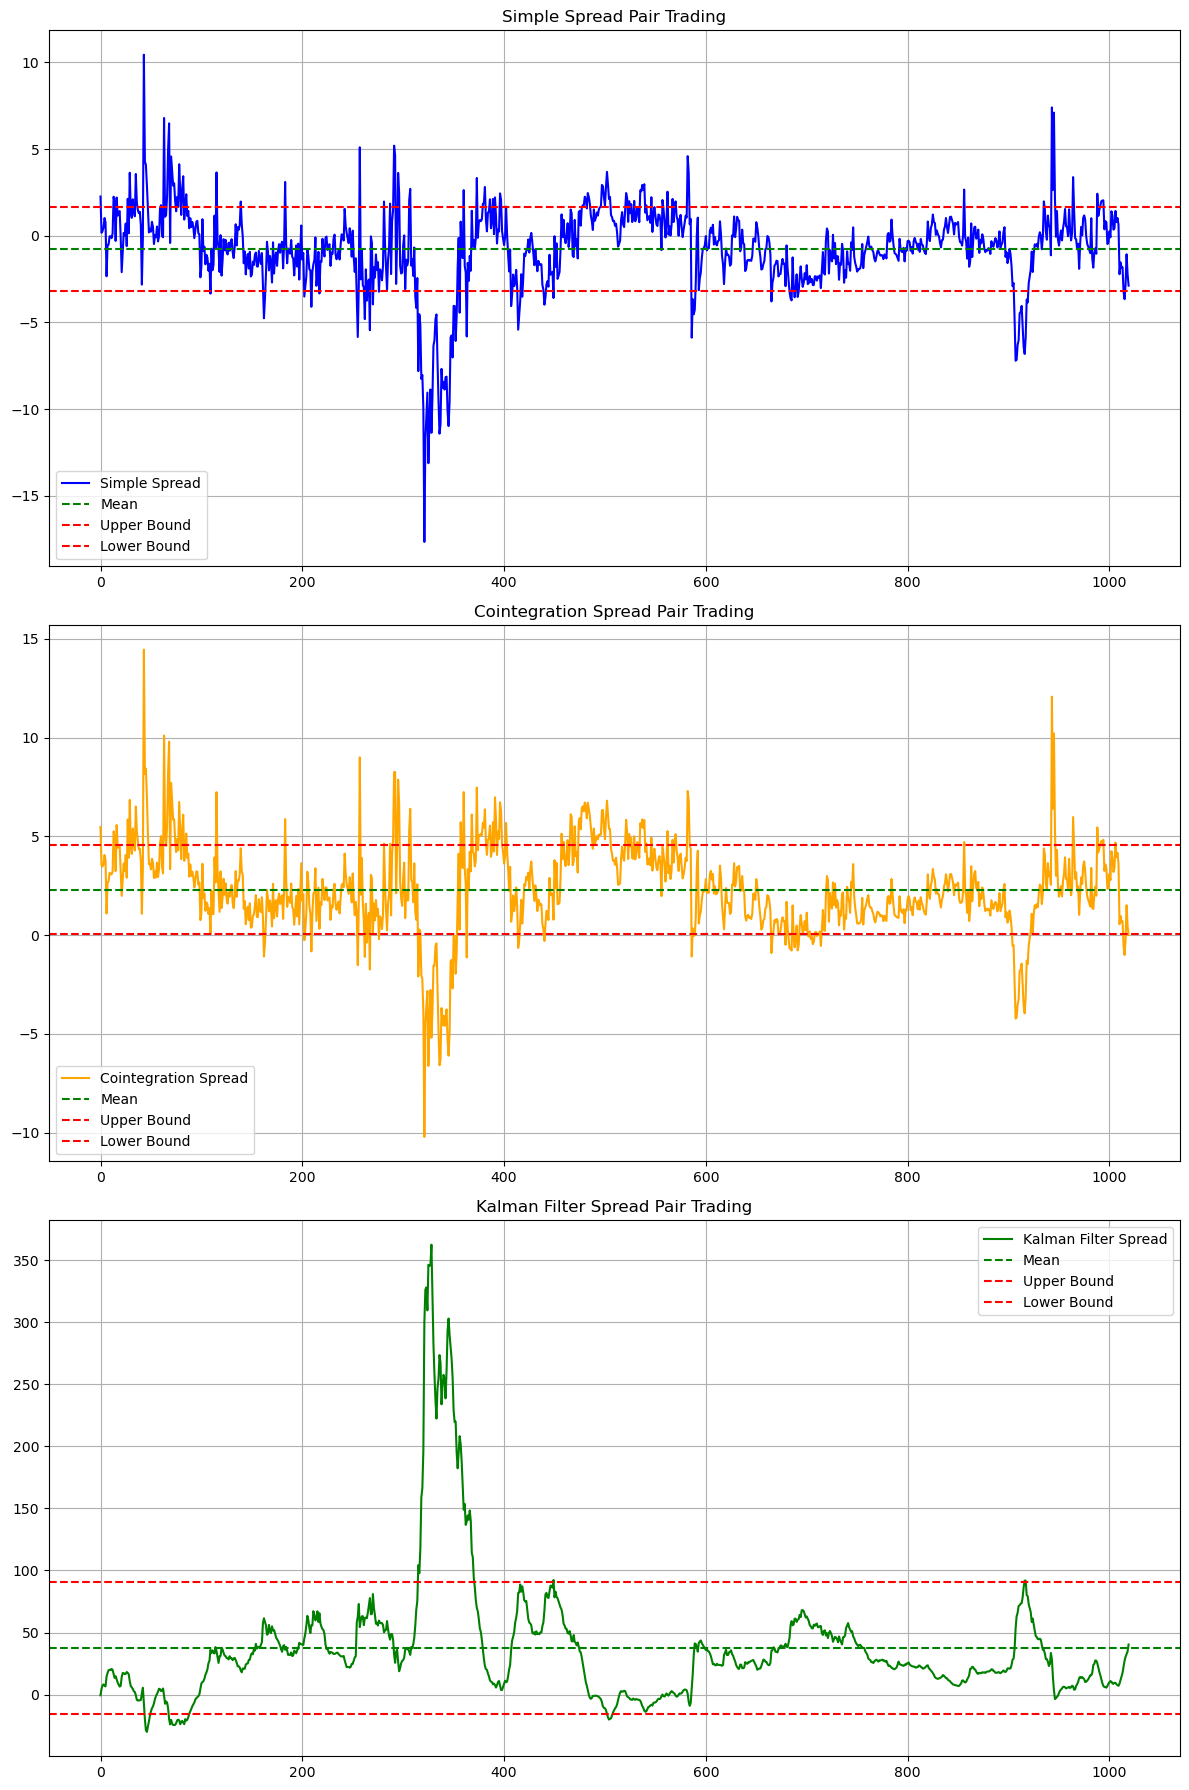

In [30]:
# Plot all three spreads as subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # 3 rows, 1 column

# Simple Spread Plot
axes[0].plot(simple_signals['Spread'], label='Simple Spread', color='blue')
axes[0].axhline(simple_signals['Spread'].mean(), color='green', linestyle='--', label='Mean')
axes[0].axhline(simple_signals['Spread'].mean() + entry_threshold * simple_signals['Spread'].std(),
                color='red', linestyle='--', label='Upper Bound')
axes[0].axhline(simple_signals['Spread'].mean() - entry_threshold * simple_signals['Spread'].std(),
                color='red', linestyle='--', label='Lower Bound')
axes[0].set_title("Simple Spread Pair Trading")
axes[0].legend()
axes[0].grid()

# Cointegration Spread Plot
coint_spread = data['V1X'] - np.polyfit(data['V2X'], data['V1X'], 1)[0] * data['V2X']
axes[1].plot(coint_spread, label='Cointegration Spread', color='orange')
axes[1].axhline(coint_spread.mean(), color='green', linestyle='--', label='Mean')
axes[1].axhline(coint_spread.mean() + entry_threshold * coint_spread.std(),
                color='red', linestyle='--', label='Upper Bound')
axes[1].axhline(coint_spread.mean() - entry_threshold * coint_spread.std(),
                color='red', linestyle='--', label='Lower Bound')
axes[1].set_title("Cointegration Spread Pair Trading")
axes[1].legend()
axes[1].grid()

# Kalman Filter Spread Plot
kalman_spread = pd.Series(kalman_signals['Spread'], index=data.index)
axes[2].plot(kalman_spread, label='Kalman Filter Spread', color='green')
axes[2].axhline(kalman_spread.mean(), color='green', linestyle='--', label='Mean')
axes[2].axhline(kalman_spread.mean() + entry_threshold * kalman_spread.std(),
                color='red', linestyle='--', label='Upper Bound')
axes[2].axhline(kalman_spread.mean() - entry_threshold * kalman_spread.std(),
                color='red', linestyle='--', label='Lower Bound')
axes[2].set_title("Kalman Filter Spread Pair Trading")
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()
